In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: 'NoneType' object is not subscriptable

This is the baseline for the project. This will be implemented as various classifier models over the 29,950 training instances (15k fire = 0, 14,950 fire = 1).

In [41]:
import pandas as pd
import os
import csv
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Change directory to where you want files saved

# File containing all data
data = pd.read_csv("combined_data_fixed.csv")

X = pd.DataFrame(data)

# Drop the response from X and NaN columns
X.drop("FIRE", axis = 1, inplace = True)
X.drop("Date", axis = 1, inplace = True)
X.drop("Longitude", axis = 1, inplace = True)
X.drop("Latitude", axis = 1, inplace = True)

# Assign y to the 'FIRE' column in data
y = data['FIRE']


In [42]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=1234)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(19168, 10)
(4792, 10)
(5990, 10)
(19168,)
(4792,)
(5990,)


In [43]:
def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):
    rows = []
    for name, pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        train_preds = pipeline.predict(X_train)
        test_preds = pipeline.predict(X_evaluate)
        testing_accuracy = accuracy_score(y_evaluate, test_preds)
        testing_recall = recall_score(y_evaluate, test_preds)
        testing_precision = precision_score(y_evaluate, test_preds)
        testing_f1 = f1_score(y_evaluate, test_preds)
        rows.append({'name': name, 'Eval Accuracy': testing_accuracy,
                     'Eval Recall': testing_recall,
                      'Eval Precision': testing_precision,
                      'Eval F1': testing_f1})
    return pd.DataFrame(rows)

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, roc_curve, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import make_pipeline
knn = KNeighborsClassifier()
scaler = MinMaxScaler()

knn_baseline_pipeline = make_pipeline(knn)
knn_scaled_pipeline = make_pipeline(scaler, knn)

In [45]:
evaluate_pipelines([
    ('Baseline', knn_baseline_pipeline), ('Scaled', knn_scaled_pipeline)
], X_train, y_train, X_val, y_val)

,name,Eval Accuracy,Eval Recall,Eval Precision,Eval F1
0,Baseline,0.920701,0.944068,0.899838,0.921423
1,Scaled,0.919240,0.932627,0.906134,0.919190


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
# Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 21)),        # k from 1 to 20
    'knn__weights': ['uniform', 'distance']        # weight schemes
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Evaluate on validation set
from sklearn.metrics import classification_report
y_val_pred = grid_search.predict(X_val)
print(classification_report(y_val, y_val_pred))

Best Parameters: {'knn__n_neighbors': 17, 'knn__weights': 'distance'}
Best CV Accuracy: 0.9260223485446989
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2432
           1       0.91      0.95      0.93      2360

    accuracy                           0.93      4792
   macro avg       0.93      0.93      0.93      4792
weighted avg       0.93      0.93      0.93      4792



In [ ]:
knn_tuned = make_pipeline(scaler, KNeighborsClassifier(n_neighbors=17, weights = "distance"))

In [47]:
evaluate_pipelines([
    ('Scaled', knn_scaled_pipeline),
    ('Scaled and Tuned', knn_tuned)
], X_train, y_train, X_test, y_test)

,name,Eval Accuracy,Eval Recall,Eval Precision,Eval F1
0,Scaled,0.920033,0.932561,0.906923,0.919563
1,Scaled and Tuned,0.926043,0.944482,0.908287,0.926031


Validation AUC-ROC: 0.9671759136652542


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


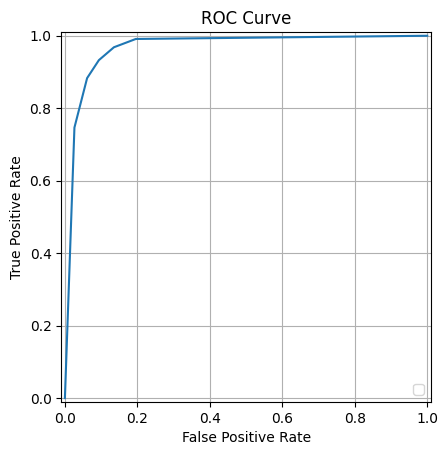

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# Get predicted probabilities for class 1 (positive class)
y_val_proba = knn_scaled_pipeline.predict_proba(X_val)[:, 1]

# Compute AUC-ROC
auc_score = roc_auc_score(y_val, y_val_proba)
print("Validation AUC-ROC:", auc_score)

# Optional: Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve")
plt.grid(True)
plt.show()


Validation AUC-ROC: 0.9786434231433987


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


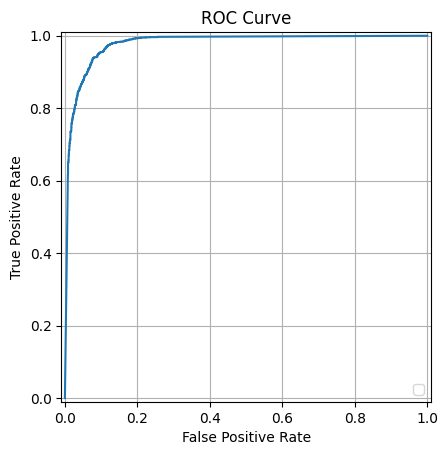

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# Get predicted probabilities for class 1 (positive class)
y_val_proba = knn_tuned.predict_proba(X_val)[:, 1]

# Compute AUC-ROC
auc_score = roc_auc_score(y_val, y_val_proba)
print("Validation AUC-ROC:", auc_score)

# Optional: Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve")
plt.grid(True)
plt.show()


In [50]:
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# Final model
final_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=17, weights='distance'))
final_knn.fit(X_train, y_train)

# Get permutation importance on validation set
perm = permutation_importance(final_knn, X_val, y_val, scoring='accuracy', n_repeats=10, random_state=42)

# Format as DataFrame
knn_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'KNN_importance': perm.importances_mean
}).sort_values(by='KNN_importance', ascending=False)

print(knn_importance_df)


              Feature  KNN_importance
6                  PS        0.352358
5                RH2M        0.023393
4              T2MDEW        0.012250
2             T2M_MAX        0.009286
1                 T2M        0.008598
3             T2M_MIN        0.007471
0                WS2M        0.006052
7   ALLSKY_SFC_LW_DWN        0.005989
9  ALLSKY_SFC_SW_DIFF        0.002108
8   ALLSKY_SFC_SW_DWN        0.000146
